In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda102]
!pip install pandas
!pip install seaborn
!pip install sklearn
!python -m spacy download en_core_web_sm

distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/include/python3.6/UNKNOWN
sysconfig: /usr/include/python3.6m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/include/python3.6/UNKNOWN
sysconfig: /usr/include/python3.6m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import spacy
import requests
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#r = requests.get('http://nlp.stanford.edu/data/glove.6B.zip')

In [ ]:
#open('glove.zip', 'wb').write(r.content) 

In [ ]:
#!unzip glove.zip

Archive:  glove.6.B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
len(embeddings_dict)

In [10]:
reviews_df = pd.read_csv('amazon_reviews.csv', index_col=0)

In [11]:
reviews_df

,rating,text
0,5,\n I tested the AA size Amazon brand battery ...
1,1,\n I've been buying AA and AAA batteries from...
2,1,\n Don't buy these. I did save a bunch of $'...
3,1,\n I loved these batteries when I first star...
4,1,\n I read a lot of reviews and convinced myse...
...,...,...
43308,4,"\n I had no issues plugging in, installing th..."
43309,5,\n This is a snappy little wheel in a great f...
43310,5,"\n Had this set for a few months now, and no ..."
43311,5,\n Actually surpassed my expectations. I open...


<AxesSubplot:xlabel='rating', ylabel='count'>

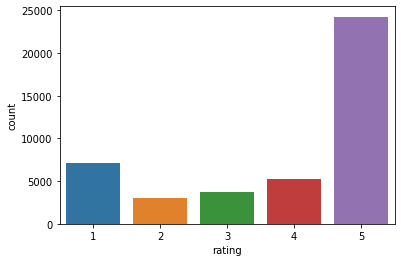

In [12]:
sns.countplot(x='rating', data=reviews_df)

In [13]:
rows_to_drop = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 17000, False)
#rows_to_drop1 = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 20000, False)
#rows_to_drop2 = np.random.choice(reviews_df[reviews_df['rating'] == 1].index, 3000, False)
#rows_to_drop3 = np.random.choice(reviews_df[reviews_df['rating'] == 4].index, 1500, False)
#rows_to_drop = np.concatenate([rows_to_drop1, rows_to_drop2, rows_to_drop3])
reviews_df.drop(rows_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='rating', ylabel='count'>

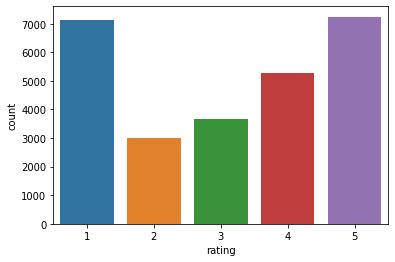

In [14]:
sns.countplot(x='rating', data=reviews_df)

In [15]:
MAX_SEQ_LEN = 500#reviews_df.text.apply(lambda x: len(x.split(" "))).max()

In [16]:
text = reviews_df.text.values
label = reviews_df.rating.values

In [17]:
tokenizer = Tokenizer()

In [18]:
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index

In [19]:
len(word_index)

32164

In [20]:
seqs = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
seqs

array([[   0,    0,    0, ...,  100,  168,  908],
       [   0,    0,    0, ..., 1226,  239, 8296],
       [   0,    0,    0, ...,  100,   23,  611],
       ...,
       [   0,    0,    0, ...,  198,   64, 2694],
       [   0,    0,    0, ...,  510,  154,    9],
       [   0,    0,    0, ...,    5,  528, 5484]], dtype=int32)

In [21]:
target = tf.keras.utils.to_categorical(label)
target = target[:, 1:]
target.shape

(26313, 5)

In [22]:
train_X, test_X, train_y, test_y = train_test_split(seqs, target, test_size=0.25, stratify=target)

In [23]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

In [24]:
for word, index in word_index.items():
    vector = embeddings_dict.get(word)
    
    if vector is not None:
        embedding_matrix[index] = vector

In [27]:
model = Sequential()

model.add(Embedding(
    len(word_index)+1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=False)
)
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_regularizer=tf.keras.regularizers.L2(0.05))))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(0.05))))

model.add(GlobalAveragePooling1D())
model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.L2(0.1)))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          9649500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 128)          186880    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 256)          263168    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'lstm_model_checkpoints',
    monitor="val_accuracy",
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience = 3, 
    verbose=1,
    factor=0.5, 
    min_lr=0.00001)

In [31]:
h = model.fit(
    train_X, 
    train_y, 
    batch_size=128, 
    epochs=35, 
    validation_data=(test_X, test_y),
    callbacks=[checkpoint_callback, early_stopping, learning_rate_reduction],
)

Epoch 1/35
155/155 [==============================] - 34s 187ms/step - loss: 0.6457 - accuracy: 0.7779 - val_loss: 1.1011 - val_accuracy: 0.6580


INFO:tensorflow:Assets written to: lstm_model_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_model_checkpoints/assets


Epoch 2/35
155/155 [==============================] - 28s 179ms/step - loss: 0.6000 - accuracy: 0.7950 - val_loss: 1.0462 - val_accuracy: 0.6749


INFO:tensorflow:Assets written to: lstm_model_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_model_checkpoints/assets


Epoch 3/35
155/155 [==============================] - 28s 179ms/step - loss: 0.5888 - accuracy: 0.7960 - val_loss: 1.1719 - val_accuracy: 0.6541
Epoch 4/35
155/155 [==============================] - 28s 179ms/step - loss: 0.6057 - accuracy: 0.7873 - val_loss: 1.2220 - val_accuracy: 0.6442
Epoch 5/35
155/155 [==============================] - 28s 179ms/step - loss: 0.5977 - accuracy: 0.7975 - val_loss: 1.1920 - val_accuracy: 0.6744

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/35
155/155 [==============================] - 28s 179ms/step - loss: 0.5262 - accuracy: 0.8197 - val_loss: 1.2350 - val_accuracy: 0.6411
Epoch 7/35
155/155 [==============================] - 28s 179ms/step - loss: 0.5442 - accuracy: 0.8100 - val_loss: 1.1027 - val_accuracy: 0.6699
Epoch 8/35
155/155 [==============================] - 28s 179ms/step - loss: 0.5126 - accuracy: 0.8258 - val_loss: 1.1157 - val_accuracy: 0.6700

Epoch 00008: ReduceLROnPlateau reducing learning

Text(0.5, 1.0, 'Accuracy')

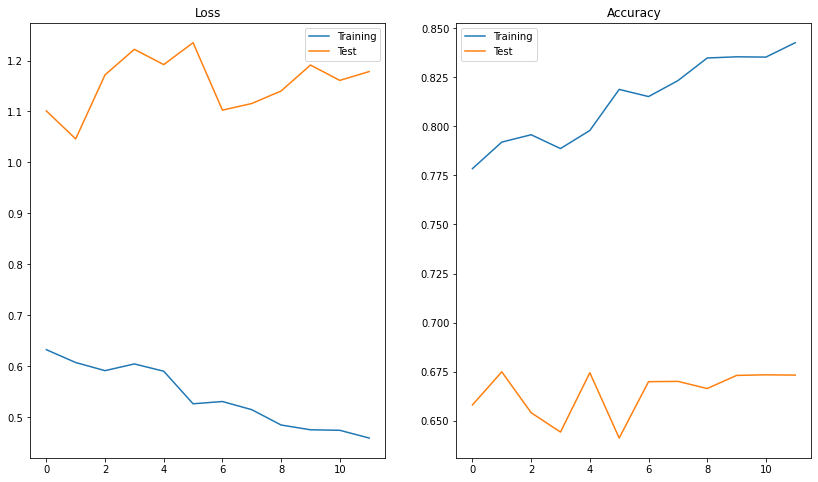

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

ax[0].plot(h.history['loss'], label='Training')
ax[0].plot(h.history['val_loss'], label='Test')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(h.history['accuracy'], label='Training')
ax[1].plot(h.history['val_accuracy'], label='Test')
ax[1].legend()
ax[1].set_title('Accuracy')

In [34]:
model.evaluate(train_X, train_y)

617/617 [==============================] - 18s 29ms/step - loss: 0.4668 - accuracy: 0.8626


[0.46683448553085327, 0.862572193145752]

In [33]:
model.evaluate(test_X, test_y)

206/206 [==============================] - 6s 30ms/step - loss: 1.0462 - accuracy: 0.6749


[1.0461947917938232, 0.6748746037483215]

In [ ]:
preds = model.predict(test_X)
np.apply_along_axis(lambda x: x/x.sum(), 1, confusion_matrix(np.argmax(test_y, axis=1), np.argmax(preds, axis=1)))